In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tkinter as tk
from PIL import Image, ImageDraw
from tqdm import tqdm

graphics_path = r'C:\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\acc_graphics'
assets_path = r'C:\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\assets_mnist'

# Cargar el archivo CSV
df = pd.read_csv("https://raw.githubusercontent.com/MartinSchubert04/Neural-Network/refs/heads/main/datasets/mnist.csv")

data = np.array(df)

np.random.seed(0)

muestras, columnas = data.shape
print(muestras, columnas)

np.random.shuffle(data) # mezclo para evitar overffitting

empiezaTest = TerminaTrain = 9000

data_test = data[empiezaTest:, :].T # hago que cada uestra sea una columna y no una fila como antes
Y_test = data_test [0]
X_test = data_test [1:]
mean = np.mean(X_test)
std_test = np.std(X_test)

# Normalizar usando desviación estándar
X_test = (X_test - mean) / std_test
# X_test = X_test / 255. # Normalizar entre 0 y 1

data_train = data[:TerminaTrain].T # hago que cada muestra sea una columna y no una fila como antes
Y_train = data_train[0] # la col 0 es el label
X_train = data_train[1:]
mean = np.mean(X_train)
std_dev = np.std(X_train)

# Normalizar usando desviación estándar
X_train = (X_train - mean) / std_dev
# X_train = X_train / 255.

print(X_test.shape)
print(Y_test.shape)
print(X_train.shape)
print(Y_train.shape)
print(np.unique(Y_train, return_counts=True))

10000 785
(784, 1000)
(1000,)
(784, 9000)
(9000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 882, 1025,  924,  915,  880,  797,  861,  925,  881,  910]))


100%|██████████| 50000/50000 [00:25<00:00, 1938.29it/s]


Test accuracy: 0.938  Train accuracy: 0.978  Min Loss: 1.6611789351579244e-06


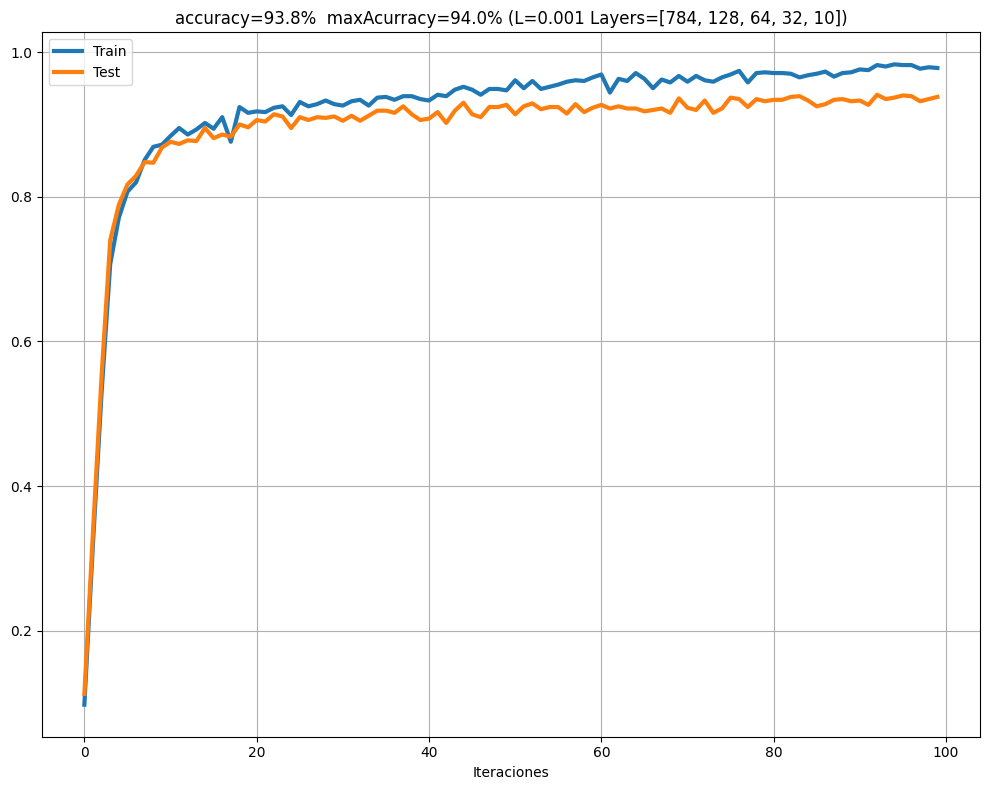

In [4]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate, iterations):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.len_L = len(layer_sizes) - 1 # Cantidad de capas menos la primera, asi mi capa de salida queda A + len(layer_sizes), y A0 = inputs
        self.layer_sizes = layer_sizes
        
        # Inicializar pesos y sesgos para cada capa
        self.parameters = {}
        for i in range(1, self.len_L + 1):
            # randn os inicia entre -0,5 y 0.5
            self.parameters['W' + str(i)] = np.random.randn(layer_sizes[i], layer_sizes[i-1]) / np.sqrt(layer_sizes[i-1]) # las filas son la cantidad de neuronas de la capa actual, y las columnas son la cantidad de neuronas de la capa actual - 1, ademas divido por la raiz cuadrada del la cant de neuronas de la capa anterior para tener valores mas chicos
            self.parameters['b' + str(i)] = np.zeros((layer_sizes[i], 1)) # inicio los bias en cero asi se va ajustando a medida que entrena
        
        # inicio los arrays para los graficos
        self.accuracy_train_l = []
        self.accuracy_test_l = []
        self.loss_l = []
        
        # uso un subset para los graficos ya que si uso todo el dataset, este pasaria todas las muestras por el forward por cada iteracion lo que causaia que tarde mucho en entrenarse
        subset_size = 1000
        
        self.X_train_subset = X_train[:, 0:subset_size]
        self.Y_train_subset = Y_train[0:subset_size]
        self.X_test_subset = X_test[:, 0:subset_size]
        self.Y_test_subset = Y_test[0:subset_size]

    # Funciones de activación
    def relu(self, x):
        return np.maximum(x, 0)
    
    def d_relu(self, x):
        return x > 0
    
    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z))
        return exp_Z / exp_Z.sum(axis=0)

    def forward_prop(self, X):
        L = self.len_L # cant layers - 1
        
        forward_results = {} # inicio un diccionario para almacenar resultados
        forward_results["A0"] = X # defino los inputs como una "capa de salida inicial" para usarlo en el for
        
        for i in range(1, L):  # Propagación para capas ocultas
            forward_results["Z" + str(i)] = self.parameters["W" + str(i)] @ forward_results["A" + str(i-1)] + self.parameters["b" + str(i)]  # la formula es Z = Wl * Al-1 + bl siendo l la capa actual
            forward_results["A" + str(i)] = self.relu(forward_results["Z" + str(i)])

        # calculo por separado la ultima capa
        forward_results["Z" + str(L)] = self.parameters["W" + str(L)] @ forward_results["A" + str(L-1)] + self.parameters["b" + str(L)] 
        forward_results["A" + str(L)] = self.softmax(forward_results["Z" + str(L)])
        
        # retorno a capa de salida y los resultados
        return forward_results["A" + str(L)], forward_results

    # tomo el valor de Y, creo un array del tamaño de las clases y en la pos = Y le asigno un 1, los demas son 0
    def one_hot_encode(self, Y):
        one_hot_Y = np.zeros((10, Y.shape[0]))
        one_hot_Y[Y] = 1
        return one_hot_Y

    def backward_prop(self, forward_results, parameters, Y, AL):
        backward_results = {} # diccionario con los resultados
        L = self.len_L 
        one_hot_Y = self.one_hot_encode(Y)

        # primero calculo los usados en la capa de salida
        backward_results["dZ" + str(L)] = AL- one_hot_Y
        backward_results["dW" + str(L)] = backward_results["dZ" + str(L)] @ forward_results["A" + str(L-1)].T
        backward_results["db" + str(L)] = np.sum(backward_results["dZ" + str(L)], axis = 1, keepdims = True)
        
        # luego busco de adelante para atras los W y b de as capas ocultas
        for i in reversed(range(1, L)):
            backward_results["dZ" + str(i)] = parameters["W" + str(i+1)].T @ backward_results["dZ" + str(i+1)] * self.d_relu(forward_results["Z" + str(i)])
            backward_results["dW" + str(i)] = backward_results["dZ" + str(i)] @ forward_results["A" + str(i-1)].T
            backward_results["db" + str(i)] = np.sum(backward_results["dZ" + str(i)], axis = 1, keepdims = True)
            
        return backward_results
    
    def update_params(self, parameters, backward_results, learning_rate):
        L = learning_rate
        len_L = self.len_L
        
        for i in range(1, len_L+1):
            parameters["W" + str(i)] -= L * backward_results["dW" + str(i)]
            parameters["b" + str(i)] -= L * backward_results["db" + str(i)] 
            
        return parameters

    def train(self, X_train, Y_train):
        for i in tqdm(range(self.iterations)):
            # seleccionar aleatoriamente uno de los datos de entrenamiento
            idx = np.random.choice(X_train.shape[1], 1, replace=False)
            X_sample = X_train[:, idx]
            Y_sample = Y_train[idx]

            # pasar datos seleccionados aleatoriamente a través de la red neuronal
            AL, forward_results = self.forward_prop(X_sample)

            # distribuir error a través de la retropropagación
            backward_results = self.backward_prop(forward_results, self.parameters, Y_sample, AL)

            # actualizar pesos y sesgos
            self.parameters = self.update_params(self.parameters, backward_results, self.learning_rate)
            

            if i % (self.iterations // 100) == 0: # divide las iteraciones por 100, entonces va a haber 100 puntos de calculo de presicion (esto mejora mucho la velocidad de eecucion de cada iteracion)
                # Calcular precisión del conjunto de prueba
                test_predictions = self.forward_prop(self.X_test_subset)[0] # tomo del forward la capa de salida con los esultados de todas las muestras
                test_comparisons = np.argmax(test_predictions, axis=0) == self.Y_test_subset # comparo con los output reales
                accuracy_test = np.mean(test_comparisons)
                self.accuracy_test_l.append(accuracy_test)
                    
                # Calcular precisión del conjunto de entrenamiento
                train_predictions = self.forward_prop(self.X_train_subset)[0] 
                train_comparisons = np.argmax(train_predictions, axis=0) == self.Y_train_subset 
                accuracy_train = np.mean(train_comparisons)
                self.accuracy_train_l.append(accuracy_train)
                
                # Calcular y almacenar la pérdida
                loss = -np.sum(self.one_hot_encode(Y_sample)* np.log(forward_results["A" + str(self.len_L)] + 1e-8)) / Y_sample.shape[0]
                self.loss_l.append(loss)
            
            # en caso de que se llegue a un valor de entrenamiento muy alto antes de las iters determinadas el for se corta
            if accuracy_test >= 0.98 and accuracy_train >= 0.98:
                print("El entrenamiento termino antes de lo esperado debido a que se alcanzo valores extremadamente optimos")
                break

        print(f"Test accuracy: {accuracy_test}  Train accuracy: {accuracy_train}  Min Loss: {np.min(self.loss_l)}")
        self.accuracy_graphic()   

    # formula para calcular la perdida en multiclases
    def cross_entropy_loss(self, A2, Y):
        one_hot_Y = self.one_hot_encode(Y)
        loss = -np.sum(one_hot_Y * np.log(A2 + 1e-8))  # 1e-8 para evitar log(0)
        return loss
    
    # grafico de las precicion de test y train en funcion de las iteraciones realizadas
    def accuracy_graphic(self):
        iters = self.iterations
        L = self.learning_rate
        Layers = self.layer_sizes
        accuracy = round(float(self.accuracy_test_l[-1] * 100), 2)
        maxAcurracy = round(float(np.max(self.accuracy_test_l)), 2) * 100
        fmt_train = {
            'color': 'tab:blue',
            'ls': 'solid',
            'lw': 3,
        }
        fmt_test = {
            'color': 'tab:orange',
            'ls': 'solid',
            'lw': 3,
        }

        fig, (ax) = plt.subplots(1, 1, figsize=(10, 8))
        ax.plot(self.accuracy_train_l, label='Train', **fmt_train)
        ax.plot(self.accuracy_test_l, label='Test', **fmt_test)

        ax.grid(which='both')
        ax.legend()
        ax.set_title(f'{accuracy=}%  {maxAcurracy=}% ({L=} {Layers=})')
        ax.set_xlabel('Iteraciones')

        fig.tight_layout()
        plt.savefig( os.path.join(graphics_path, f"{accuracy=}%_{L=}_{iters=}_{Layers=}.png"))
        plt.show()
        


# Ejemplo de uso
iters = 50_000
L = 0.001
layer_sizes = [X_train.shape[0], 128, 64, 32,  10]# primer layer = cant inputs, ultimo = cant clases


nn = NeuralNetwork(layer_sizes, L, iters)
nn.train(X_train, Y_train)

In [18]:
imagen_contador = 0  # Para dar nombres únicos a las imágenes guardadas

class DibujarNumero:
    def __init__(self, root):
        self.root = root
        self.root.title("Dibuja un número")
        
        # Crear un lienzo de 200x200 para dibujar
        self.canvas = tk.Canvas(self.root, width=200, height=200, bg='black')
        self.canvas.grid(row=0, column=0, pady=2, sticky=tk.W, columnspan=2)
        
        # asocia el boton izquierdo de mouse, para el evento dibujar
        self.canvas.bind("<B1-Motion>", self.dibujar)
        
        # muestra el texto con la prediccion actual
        self.prediccion_label = tk.Label(self.root, text="Predicción: -", font=("Helvetica", 14))
        self.prediccion_label.grid(row=2, column=0, columnspan=2, pady=5) # defino en que parte de la ventana se ubica
        
        # creo un boton para guardar la imagen llamando a la funcion guardar
        self.guardar_btn = tk.Button(self.root, text = "Guardar", command = self.guardar)
        self.guardar_btn.grid(row=1, column=0, pady=2) # defino en que parte de la ventana se ubica
        
        # creo el boton para borrar el dibujo en ventana
        self.limpiar_btn = tk.Button(self.root, text="Limpiar", command=self.limpiar_lienzo)
        self.limpiar_btn.grid(row=1, column=1, pady=2) # defino en que parte de la ventana se ubica
    
        # creo una imagen para dibujar en ella (PIL)
        self.imagen_pil = Image.new("L", (20, 20), 0)  # # 20x20 con fondo negro
        self.draw = ImageDraw.Draw(self.imagen_pil)
        self.root.protocol("WM_DELETE_WINDOW", self.cerrar_aplicacion) # para que termine el proceso al cerrar la ventana
    
    # funcion que devuelve el numero de fila en la que A2 tiene el valor mas ato
    def get_predictions(self, AL):
        return np.argmax(AL, axis=0) 

    def make_predictions(self, X):
        AL, _ = nn.forward_prop(X)
        predictions = self.get_predictions(AL)
        return predictions

    def dibujar(self, event):
        x, y = event.x, event.y
        r = 4 # radio del pincel
        
        self.canvas.create_oval(x - r, y - r, x + r, y + r, fill='white', outline='white') # crea el circulo para dibujar
        
        # Preprocesar la imagen para el modelo
        imagen_28x28 = Image.new("L", (28, 28), 0)  # Crear una nueva imagen 28x28 con fondo negro
        imagen_28x28.paste(self.imagen_pil, (4, 4))  # Pegar la imagen 20x20 en el centro con 4 píxeles de margen

        imagen_array = np.array(imagen_28x28)  # Convertir la imagen a un array
        imagen_array = imagen_array.reshape(-1, 1)  #  reshape de (1,784) a (784, 1) para que coincida la entrada de inputs
        imagen_array = imagen_array / 255.0  # Normalizar 

        # Hacer la predicción
        prediccion = self.make_predictions(imagen_array)

        # Actualizar la etiqueta de predicción
        self.prediccion_label.config(text=f"Predicción: {prediccion[0]}")
        
        # Dibujar en la imagen PIL (convertimos coordenadas 200x200 a 20x20)
        self.draw.ellipse((x / 10 - r / 10, y / 10 - r / 10, x / 10 + r / 10, y / 10 + r / 10), fill='white')
        
        self.actualizar_canvas()
        
    def actualizar_canvas(self):
        # Crear una versión ampliada de la imagen de 20x20
        imagen_ampliada = self.imagen_pil.resize((200, 200), Image.Resampling.NEAREST)
        self.image_tk = ImageTk.PhotoImage(imagen_ampliada)
        self.canvas.create_image(0, 0, anchor=tk.NW, image=self.image_tk)
    
    def limpiar_lienzo(self):
        # Limpiar el canvas de tkinter
        self.canvas.delete("all")
        
        # Limpiar la imagen PIL
        self.imagen_pil = Image.new("L", (20, 20), 0)  # nuevo fondo de 20x20 con fondo negro
        self.draw = ImageDraw.Draw(self.imagen_pil)
        
    def guardar(self):
        global imagen_contador

        # Añadir 4 píxeles de margen en cada dirección (crear una imagen de 28x28)
        imagen_28x28 = Image.new("L", (28, 28), 0)  # Crear una nueva imagen 28x28 con fondo negro
        imagen_28x28.paste(self.imagen_pil, (4, 4))  # Pegar la imagen 20x20 en el centro con 4 píxeles de margen
        # Guardar la imagen
        ruta_imagen = os.path.join(assets_path, f"numero_{imagen_contador}.png")
        imagen_28x28.save(ruta_imagen)
        print(f"Imagen guardada en: {ruta_imagen}")
        
        # incrementar el contador para la próxima imagen
        imagen_contador += 1
        
    def cerrar_aplicacion(self):
        print("Cerrando la aplicación...")
        self.root.destroy()  # detener el mainloop y cerrar la ventana

# ventana de tkinter
root = tk.Tk()

# inicio la app
app = DibujarNumero(root)

# Ejecutar el mainloop de tkinter
root.mainloop()

Cerrando la aplicación...


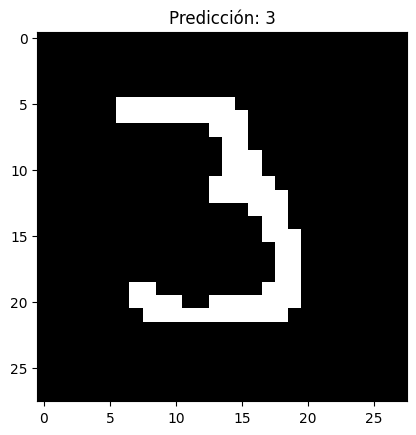

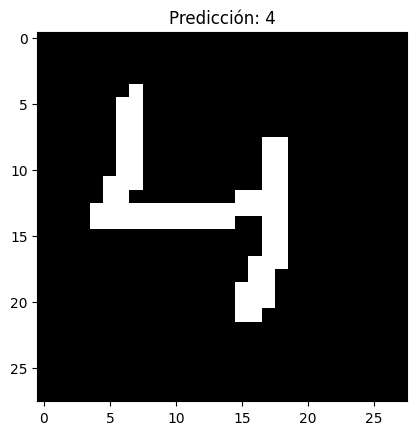

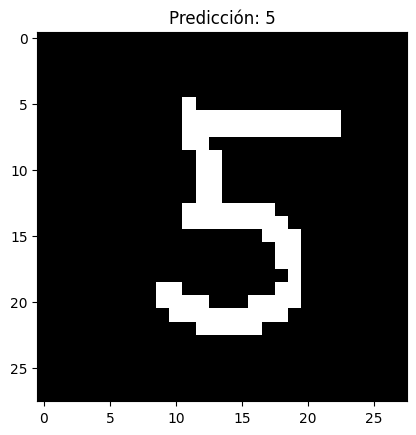

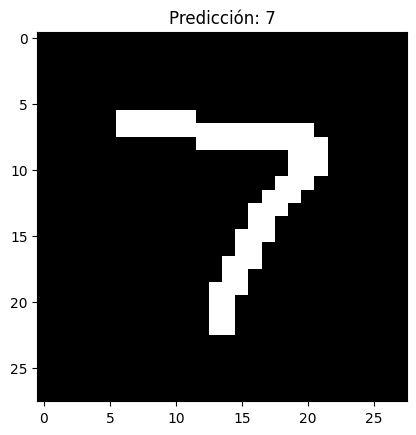

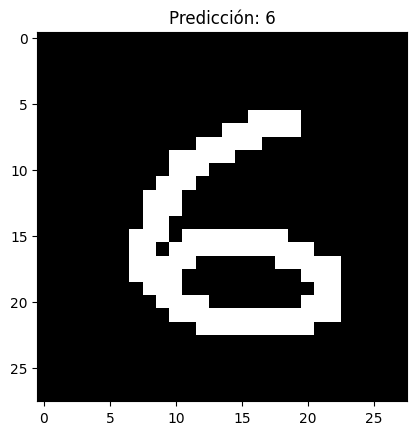

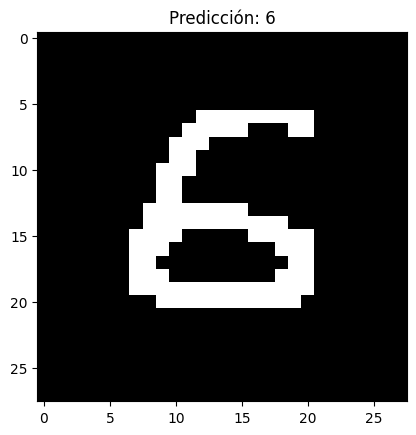

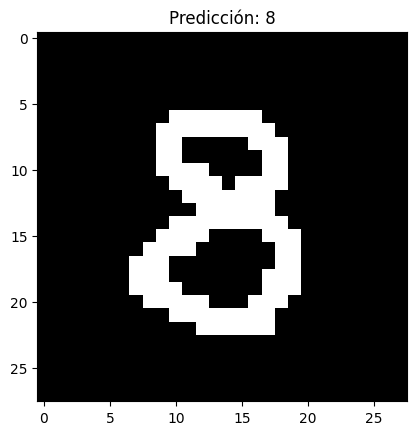

In [32]:
# funcion que devuelve el numero de fila en la que A2 tiene el valor mas ato
def get_predictions(AL):
    return np.argmax(AL, axis=0) 

def make_predictions(X):
    AL, _ = nn.forward_prop(X)
    predictions = get_predictions(AL)
    return predictions


# Función para procesar una imagen
def procesar_imagen(ruta_imagen):
    # Cargar la imagen
    img = Image.open(ruta_imagen)
    
    # Convertir a escala de grises
    img = img.convert('L')
    
    # Redimensionar a 28x28 píxeles
    img = img.resize((28, 28))
    
    # Convertir la imagen a un array numpy
    img_array = np.array(img)
    
    # Invierte los colores restandle el valor original a 255 y se lo asigna osea si es blanco (255) y se lo restas a 255 entonces te queda negro
    # img_array = 255 - img_array
    
    # Escalar los valores de los píxeles entre 0 y 1
    img_array = img_array / 255.0
    
    # Aplanar la imagen para que sea un vector de 784 dimensiones (28x28)
    img_array = img_array.flatten()
    
    # Convertir a formato adecuado para el modelo (1 imagen)
    return img_array.reshape(1, -1)

# Función para mostrar la imagen junto con su predicción
def mostrar_imagen_con_prediccion(img_array, prediccion):
    # Convertir el array plano de 784 de vuelta a una matriz 28x28
    img_reshaped = img_array.reshape(28, 28)
    
    # Mostrar la imagen usando matplotlib
    plt.title(f'Predicción: {prediccion}')
    plt.imshow(img_reshaped, cmap='gray')
    plt.show()

# Ruta de la carpeta con las imágenes
carpeta_imagenes = r'\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\assets_mnist'

# Obtener una lista de todos los archivos en la carpeta
imagenes = [f for f in os.listdir(carpeta_imagenes) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Recorrer cada imagen en la carpeta
for imagen_nombre in imagenes:
    ruta_imagen = os.path.join(carpeta_imagenes, imagen_nombre)
    
    # Procesar la imagen
    imagen_procesada = procesar_imagen(ruta_imagen)
    
    # Realizar la predicción con el modelo entrenado
    prediccion = make_predictions(imagen_procesada.T)
    
    # Mostrar la imagen con su predicción
    mostrar_imagen_con_prediccion(imagen_procesada, prediccion[0])